# ***Identifying Product Review Segments - Feature Engineering***

**Project Description:** This project aims to identify the key segmentations within a product's reviews.

**Project Goal:** The goal of this project is to better understand the different groupings of reviews received for a product and the size of each. Essentially we're looking to classify and understand trends in product reviews.

**File Description:** In this file we conduct exploration of the review dataset and perform clustering

**Content warning:** This file uses actual steam game reviews so there is some nsfw content

**Results & Highlights:**

*   Reviews were filtered to only include those with 20+ tokens so that the reviews we included were long enough to contain meaningful content
*   Basic clustering methods like MeansShift and KMeans were unsuccessful on this dataset
*  Topic modelling via BERTopic gave us our best results with a silhouette score of 0.34, which still is not great. There is a lot of repetition and very generic reviews that are not classified well.
*   A significant chunk of reviews (12k) were in the outliers/stopwords topic



**Top Topics:**

*   Terraria Minecraft Comparison (18k reviews)
*   2D Sandobox like Minecraft (6k reviews)
*   Modding (3k reviews)
*   Journeys End Update (1k reviews)
*   Worth the Price (1k reviews)








# **File Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import spacy
#nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
#from gensim import corpora, matutils
#from gensim.corpora.dictionary import Dictionary
#from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy as sch

!pip install bertopic
from bertopic import BERTopic

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score

import os
import io
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
reviews = pd.read_pickle('/content/drive/My Drive/shared_folder/adjusted_reviews.pkl')

In [ ]:
reviews.shape

(283734, 13)

# **Tokenization / Stop Words / Lemmatization**

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283734 entries, 0 to 360389
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   app_id               283734 non-null  int64  
 1   app_name             283734 non-null  object 
 2   review_id            283734 non-null  int64  
 3   language             283734 non-null  object 
 4   review               283734 non-null  object 
 5   timestamp_updated    283734 non-null  int64  
 6   recommended          283734 non-null  bool   
 7   votes_helpful        283734 non-null  int64  
 8   votes_funny          283734 non-null  int64  
 9   weighted_vote_score  283734 non-null  float64
 10  comment_count        283734 non-null  int64  
 11  steam_purchase       283734 non-null  bool   
 12  sentiment_score      283734 non-null  float64
dtypes: bool(2), float64(2), int64(6), object(3)
memory usage: 26.5+ MB


In [ ]:
#Removing duplicates
reviews = reviews.drop_duplicates(subset='review_id', keep='first')

In [ ]:
#Our reviews data contains a lot of game names, character names, developer names etc that we want to remove
#Here we are defining our word pool as the standard dictionary word set.
#Later we will remove anything that is not found in this word set
nltk.download('words')
standard_words = set(words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
#Tokenize and lemmatize
reviews['tokens'] = reviews['review'].apply(lambda x: [token.lemma_.lower() for token in nlp(x)
               if not token.is_stop and not token.is_punct])

# Remove tokens that are not in standard_words
#reviews_reduced['tokens'] = reviews_reduced['tokens'].apply(lambda tokens: [token for token in tokens if token in standard_words])

reviews.head()

,app_id,app_name,review_id,language,review,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,sentiment_score,tokens
0,105600,Terraria,85105575,en,Very good and very addicting game! I recommend...,1611259145,True,0,0,0.0,0,True,0.8594,"[good, addict, game, recommend, lot, like, poi..."
1,105600,Terraria,85105565,en,i like everything about this game but i'm not ...,1611259131,True,0,0,0.0,0,True,-0.7162,"[like, game, go, to, good, describe, will]"
2,105600,Terraria,85105421,en,Its Gucci to all players seaking a god damn ch...,1611258908,True,0,0,0.0,0,True,-0.0772,"[gucci, player, seake, god, damn, challenge]"
3,105600,Terraria,85105168,en,this game was my favorite and still is one of ...,1611258546,True,0,0,0.0,0,True,0.7896,"[game, favorite, top, year, game, bore]"
4,105600,Terraria,85105061,en,Great game now give me awards\n,1611258406,True,0,0,0.0,0,True,0.7964,"[great, game, award, \n]"


In [ ]:
pd.to_pickle(reviews, '/content/drive/My Drive/shared_folder/reviews_tokenized.pkl')

In [9]:
reviews_tokens = pd.read_pickle('/content/drive/My Drive/shared_folder/reviews_tokenized.pkl')

# **Review Length Check**

To get meaningful results, the reviews need to be long enough to contain multiple tokens.

In [ ]:
reviews_tokens.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283734 entries, 0 to 360389
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   app_id               283734 non-null  int64  
 1   app_name             283734 non-null  object 
 2   review_id            283734 non-null  int64  
 3   language             283734 non-null  object 
 4   review               283734 non-null  object 
 5   timestamp_updated    283734 non-null  int64  
 6   recommended          283734 non-null  bool   
 7   votes_helpful        283734 non-null  int64  
 8   votes_funny          283734 non-null  int64  
 9   weighted_vote_score  283734 non-null  float64
 10  comment_count        283734 non-null  int64  
 11  steam_purchase       283734 non-null  bool   
 12  sentiment_score      283734 non-null  float64
 13  tokens               283734 non-null  object 
dtypes: bool(2), float64(2), int64(6), object(4)
memory usage: 28.7+ MB


In [11]:
reviews_tokens['length'] = reviews_tokens['tokens'].apply(len)

In [12]:
#There are 811 reviews with no tokens which should be removed
(reviews_tokens['length'] == 0).sum()

811

In [13]:
reviews_tokens.drop(reviews_tokens[reviews_tokens['length'] == 0].index, inplace=True)

In [ ]:
lengt_df = reviews_tokens['length'].value_counts(dropna=False)
length_df = pd.DataFrame(lengt_df)

In [ ]:
length_df.head()
#There look to be a significant number of reviews that are extremely short.

,count
length,
2,40220
1,39291
3,26216
4,21119
5,17402


In [ ]:
reviews_tokens['length'].value_counts(normalize=True)
#Over 40% of our reviews have 5 or less tokens

,proportion
length,
2,0.142159
1,0.138875
3,0.092661
4,0.074646
5,0.061508
...,...
791,0.000004
783,0.000004
339,0.000004


Deciding on a token length cut off

In [ ]:
reviews_tokens[reviews_tokens['length'] == 1].head()
#These can clearly be removed

,app_id,app_name,review_id,language,review,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,sentiment_score,tokens,length
12,105600,Terraria,85103604,en,cool,1611256457,True,0,0,0.0,0,True,0.3182,[cool],1
17,105600,Terraria,85102899,en,yes,1611255556,True,0,0,0.0,0,True,0.4019,[yes],1
23,105600,Terraria,85102336,en,yes,1611254802,True,0,0,0.0,0,True,0.4019,[yes],1
27,105600,Terraria,85102143,en,yes,1611254548,True,0,0,0.0,0,True,0.4019,[yes],1
43,105600,Terraria,85100186,en,it is good,1611252117,True,0,0,0.0,0,True,0.4404,[good],1


In [ ]:
reviews_tokens[reviews_tokens['length'] == 5].head()
#These are starting to be sentences but they still dont have much substance

,app_id,app_name,review_id,language,review,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,sentiment_score,tokens,length
7,105600,Terraria,85104322,en,Terraria is a fun exploration game for all ages.,1611257438,True,0,0,0.0,0,True,0.6369,"[terraria, fun, exploration, game, age]",5
68,105600,Terraria,85093443,en,"Amazing, lots of fun with or without friends. ...",1611243472,True,0,0,0.0,0,True,0.5324,"[amazing, lot, fun, friend, recommend]",5
107,105600,Terraria,85085557,en,Golf it with friends or fight an elder evil.,1611231309,True,0,0,0.0,0,False,-0.5994,"[golf, friend, fight, elder, evil]",5
123,105600,Terraria,85079478,en,This game is very good both in mapping and pla...,1611222167,True,0,0,0.0,0,False,0.6901,"[game, good, mapping, playing, like]",5
124,105600,Terraria,85079389,en,"Just go ahead and explore...beware, you'll die...",1611222032,True,0,0,0.0,0,False,-0.5994,"[ahead, explore, beware, die, alot]",5


In [ ]:
reviews_tokens[reviews_tokens['length'] == 10].head()
#We're starting to pick up on full thoughts

,app_id,app_name,review_id,language,review,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,sentiment_score,tokens,length
165,105600,Terraria,85069249,en,it is a really big game plenty of time to get ...,1611204130,True,0,0,0.0,0,True,0.8399,"[big, game, plenty, time, play, day, come, rec...",10
284,105600,Terraria,85056335,en,"this is my favorite game of all time, ive play...",1611180999,True,0,0,0.0,0,True,0.8016,"[favorite, game, time, ve, play, 2012, believe...",10
346,105600,Terraria,85048488,en,Best. Game. Ever. Totally Recommend. Like an u...,1611169985,True,0,0,0.0,0,False,0.9131,"[well, game, totally, recommend, like, upgrade...",10
402,105600,Terraria,85040577,en,Never knew how much I would grow to love this ...,1611159654,True,0,0,0.0,0,True,0.7838,"[know, grow, love, game, come, play, game, yea...",10
445,105600,Terraria,85031749,en,I never beat it without co-op despite spending...,1611148263,True,0,0,0.0,0,True,0.4404,"[beat, co, op, despite, spend, 500, hour, well...",10


In [ ]:
print('All: ', length_df.sum())
print('>= 10: ', length_df[length_df.index >= 10].sum())
#If we only keep reviews with at least 10 tokens, we are left with 93k reviews out of 283k.
#93k is still a good sample size

All:  count    282923
dtype: int64
>= 10:  count    92654
dtype: int64


In [ ]:
reviews_tokens[reviews_tokens['length'] == 15].head()
#At this level we're starting to see some really solid feedback on the game and its features

,app_id,app_name,review_id,language,review,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,sentiment_score,tokens,length
0,105600,Terraria,85105575,en,Very good and very addicting game! I recommend...,1611259145,True,0,0,0.000000,0,True,0.8594,"[good, addict, game, recommend, lot, like, poi...",15
42,105600,Terraria,85100188,en,"Honestly one of the best games every created, ...",1611252119,True,0,0,0.000000,0,True,0.9684,"[honestly, good, game, create, solid, player, ...",15
244,105600,Terraria,85060179,en,THIS GAME FUCKING SUCKS DICK MY WORLD IS GONE ...,1611187502,False,1,1,0.478261,0,True,-0.9753,"[game, fucking, sucks, dick, world, go, game, ...",15
272,105600,Terraria,85057857,en,One of my all time favorite games and the upda...,1611183403,True,0,0,0.000000,0,True,0.8516,"[time, favorite, game, update, vast, content, ...",15
309,105600,Terraria,85053002,en,It is really fun it is a good exploration game...,1611176068,True,0,0,0.000000,0,True,0.6590,"[fun, good, exploration, game, start, boss, ba...",15


In [ ]:
print('All: ', length_df.sum())
print('>= 15: ', length_df[length_df.index >= 15].sum())
#If we only keep reviews with at least 15 tokens, we are left with 62k reviews out of 283k.
#This is still a solid sample size, but the more text we can get the better

All:  count    282923
dtype: int64
>= 15:  count    62216
dtype: int64


In [ ]:
print('All: ', length_df.sum())
print('>= 20: ', length_df[length_df.index >= 20].sum())
#If we only keep reviews with at least 20 tokens, we are left with 45k reviews out of 283k.
#This is still a solid sample size, so we'll start with this threshold

All:  count    282923
dtype: int64
>= 20:  count    45075
dtype: int64


In [14]:
reviews_tokens = reviews_tokens[reviews_tokens['length'] >= 20]

In [ ]:
reviews_tokens.shape

(45075, 15)

In [15]:
reviews_tokens.reset_index(drop=True, inplace=True)

# **BOW Approach**

In [ ]:
#Creating a dictionary
dict = corpora.Dictionary(reviews_tokens['tokens'])

In [ ]:
#Create the corpus that is a list of BoW representations for each review
#We are looking for interpretability in our results, so we're goign to start with a simple BOW approach
corpus = [dict.doc2bow(doc) for doc in reviews_tokens['tokens']]

In [ ]:
corpora.MmCorpus.serialize('corpus.mm', corpus)
loaded_corpus = corpora.MmCorpus('corpus.mm')

In [ ]:
print(loaded_corpus)

MmCorpus(45075 documents, 53371 features, 1782648 non-zero entries)


In [ ]:
sparse_matrix = matutils.corpus2csc(loaded_corpus)

In [ ]:
# Let's use TruncatedSVD for dimensionality reduction
n_components = 100  # Set the number of topics (dimensions)

# Apply TruncatedSVD to reduce dimensions
svd = TruncatedSVD(n_components=n_components, random_state=38)
lsa_matrix = svd.fit_transform(sparse_matrix)

# Normalize the LSA matrix
lsa_matrix = Normalizer(copy=False).fit_transform(lsa_matrix)

print(lsa_matrix.shape)

(53371, 100)


# KMeans Clustering

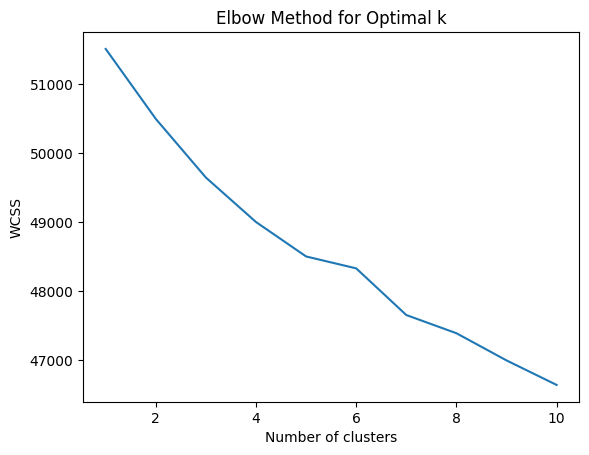

In [ ]:
#Test to find k value
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(lsa_matrix)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#Elbow poitn at 5

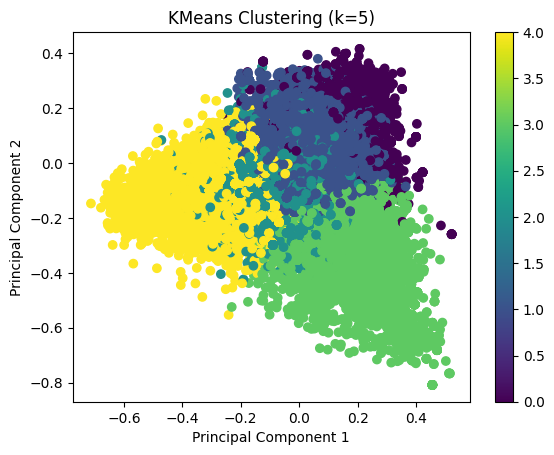

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the LSA matrix
kmeans.fit(lsa_matrix)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clustering result on PCA-reduced data (for visualization)
reduced_matrix = PCA(n_components=2).fit_transform(lsa_matrix)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

#Visually the grouping looks reasonable

In [ ]:
sil_score = silhouette_score(lsa_matrix, labels)

In [ ]:
#Pretty weak score
print(sil_score)

0.017976362116565125


# Mean Shift Clustering

Bandwidth Value:  0.1


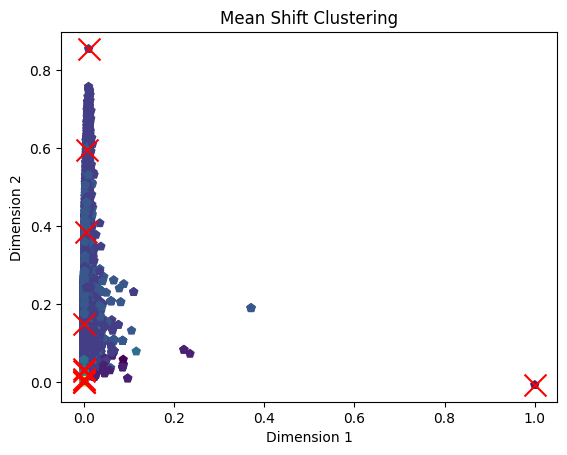

Bandwidth Value:  1.0


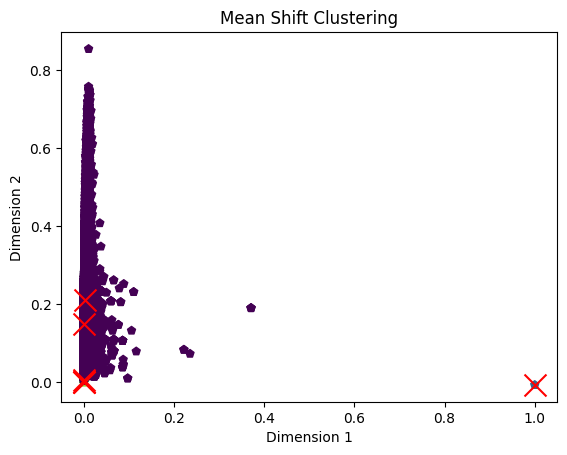

Bandwidth Value:  2.0


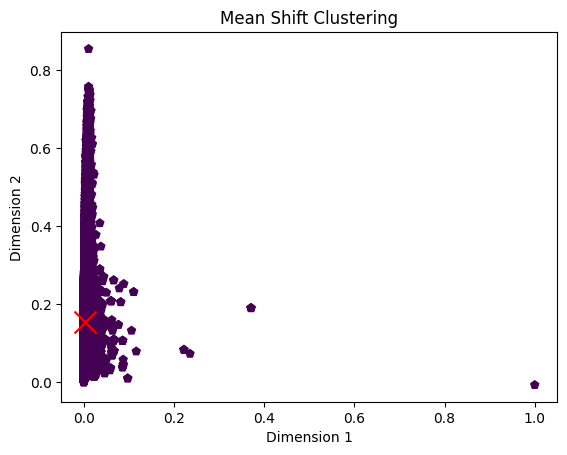

In [ ]:
bandwidth = [0.1, 1.0, 2.0]

for bw in bandwidth:
  ms = MeanShift(bandwidth=bw, bin_seeding=True)
  ms.fit(lsa_matrix)
  labels = ms.labels_
  cluster_centers = ms.cluster_centers_
  print('Bandwidth Value: ', bw)
  plt.scatter(lsa_matrix[:,0], lsa_matrix[:,1], c=labels, cmap='viridis', marker='p')
  plt.scatter(cluster_centers[:,0], cluster_centers[:,1], s=250, c='r', marker='x')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.title('Mean Shift Clustering')
  plt.show()

  #None of these look appropriate

# **Word2Vec Approach**

In [ ]:
word2vec_model = Word2Vec(reviews_tokens['tokens'], vector_size=100, window=5, min_count=5, workers=4)

word2vec_model.save("word2vec_model.model")

In [ ]:
def get_document_vector(doc, model):
    # Get word vectors for the words in the document that are in the model's vocabulary
    word_vectors = [model.wv[word] for word in doc if word in model.wv]

    if len(word_vectors) > 0:
        # Return the mean of word vectors
        return np.mean(word_vectors, axis=0)
    else:
        # Return a zero vector if none of the words in the document are in the model's vocabulary
        return np.zeros(model.vector_size)

# Create document vectors for the entire corpus
document_vectors = np.array([get_document_vector(doc, word2vec_model) for doc in reviews_tokens['tokens']])

# Check the shape of the document vectors
print(document_vectors.shape)

(45075, 100)


# KMeans Clustering

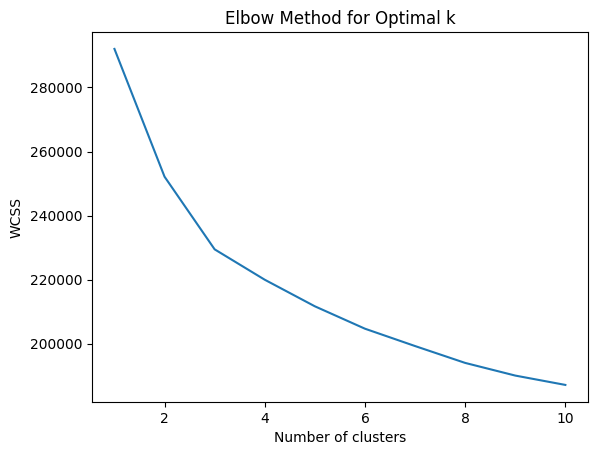

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(document_vectors)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#We'll use k=3

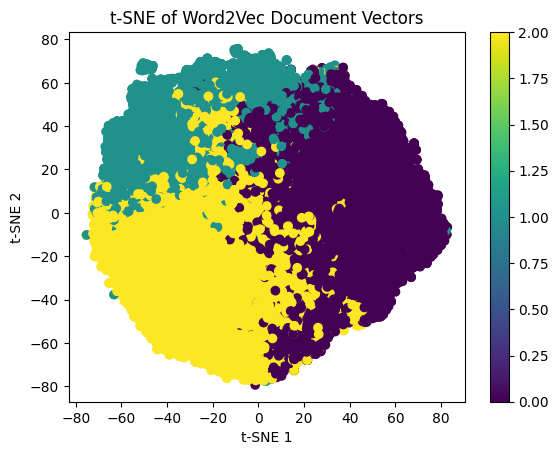

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the LSA matrix
kmeans.fit(document_vectors)

# Get the cluster labels
labels = kmeans.labels_

# Visualize the clustering result
tsne = TSNE(n_components=2, random_state=42)

reduced_vectors = tsne.fit_transform(document_vectors)

plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels)
plt.title('t-SNE of Word2Vec Document Vectors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

In [ ]:
sil_score = silhouette_score(document_vectors, labels)
print(sil_score)

#Poor performance, which is not surprising given the t-SNE

0.11781223


# **TFIDF Approach**

TFIDF Vectorizer will be applied on the raw review data rather than the tokenized reviews

In [16]:
#We will include unigrams, bigrams. Trigrams did not seem to help
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1, 2), min_df=5, max_df=0.95)

In [17]:
X_tfidf = vectorizer.fit_transform(reviews_tokens['review'])

In [ ]:
print("Shape of TF-IDF matrix:", X_tfidf.shape)

Shape of TF-IDF matrix: (45075, 71719)


In [18]:
#Scale and reduce
svd = TruncatedSVD(n_components=100)  # Reduce # of features
X_reduced = svd.fit_transform(X_tfidf)

In [ ]:
print("Shape of reduced matrix:", X_reduced.shape)

Shape of reduced matrix: (45075, 100)


# KMeans

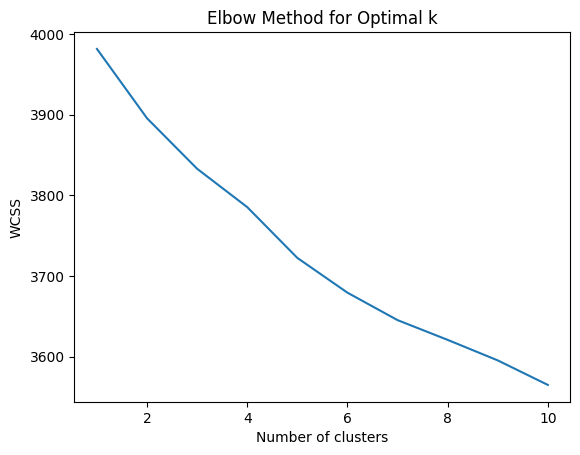

In [ ]:
#Test to find k value
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_reduced)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#Elbow point at k=5 with 100 features
#Elbow point at k=8 with 200 features

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the tfidf data
kmeans.fit(X_reduced)

# Get the cluster labels
labels = kmeans.labels_

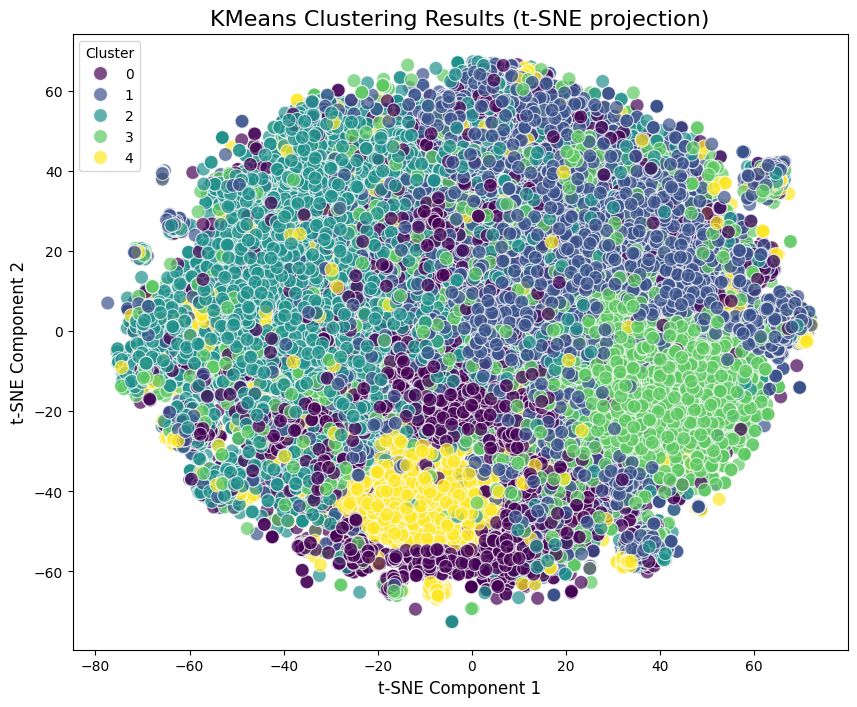

In [ ]:
#Plot clustering using t-SNE
tsne = TSNE(n_components=2, random_state=47, perplexity=30)
X_tsne = tsne.fit_transform(X_reduced)

# Create a scatter plot with the t-SNE data, color-coded by KMeans labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='viridis', s=100, alpha=0.7, marker='o')
plt.title("KMeans Clustering Results (t-SNE projection)", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Cluster", loc='best')
plt.show()

#We still aren't picking up meaningful clusters

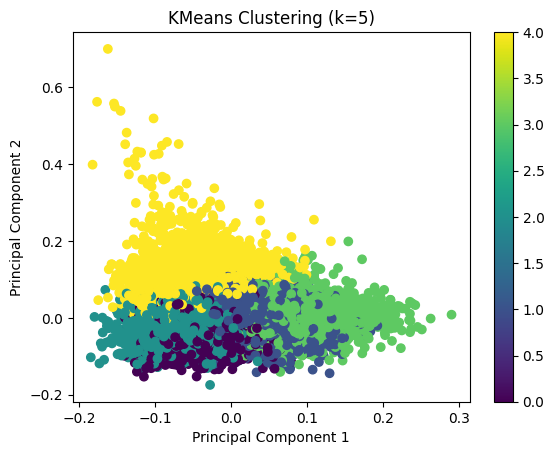

In [ ]:
# Plot the clustering result on PCA-reduced data
reduced_matrix = PCA(n_components=2).fit_transform(X_reduced)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [ ]:
sil_score = silhouette_score(X_reduced, labels)
print(sil_score)

#Still getting a weak score

0.01870600935115196


# Hierarchical

In [ ]:
#This is too intensive for my local system. This would need a MapReduce approach (We'll come back to this if neccessary)


#agg_clust = AgglomerativeClustering(n_clusters=8, linkage='single') #start with setting n since that shoudl be less intensive

#agg_clust.fit(X_reduced)
#labels = agg_clust.labels_

#mergings = linkage(X_reduced, method='single')
#dendrogram(mergings, leaf_rotation=90)
#plt.xlabel('Sample index')
#plt.ylabel('Cluster distance')
#plt.show()

# **DBScan**

In [19]:
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='cosine')
dbscan_labels = dbscan.fit_predict(X_reduced)

reviews_tokens['cluster'] = dbscan_labels

print(reviews_tokens[['review', 'cluster']])

                                                  review  cluster
0      Out of all the games I own, Terraria has to be...        0
1      i actually have around 1800 hours in this game...        0
2      i love this game the fun achievements epic bos...        0
3      Ah, yes. Terraria.\nThe one game that, when i ...        0
4      Well, this game. 2D Minecraft. (not really)\n\...        0
...                                                  ...      ...
45070  Before anyone says that this is a Minecraft Ri...        0
45071  Terraria is an amazing game. People may call i...        0
45072     Really fun game and one of my favorites eve...        0
45073  Okay so, I've started playing this game and I ...        0
45074  PLAY YEEEEZZZ GUD GAME! it is hard to get star...        0

[45075 rows x 2 columns]


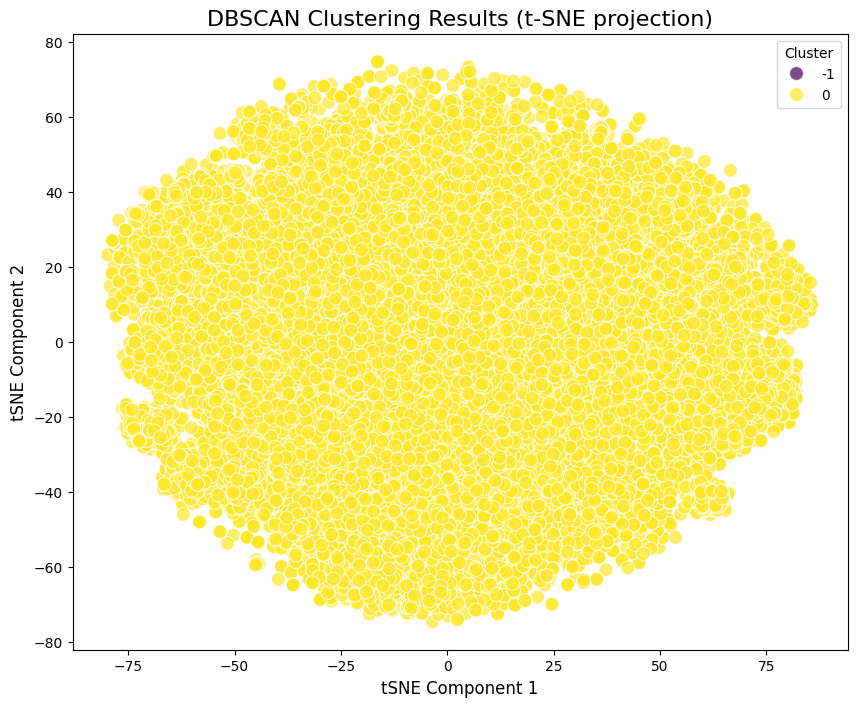

In [ ]:
tsne = TSNE(n_components=2, random_state=47, perplexity=30)
X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=dbscan_labels, palette='viridis', s=100, alpha=0.7, marker='o')
plt.title("DBSCAN Clustering Results (t-SNE projection)", fontsize=16)
plt.xlabel("tSNE Component 1", fontsize=12)
plt.ylabel("tSNE Component 2", fontsize=12)
plt.legend(title="Cluster", loc='best')
plt.show()

#Poor results with no meaningful clusters identified

In [20]:
sil_score = silhouette_score(X_reduced, dbscan_labels)

In [21]:
print(sil_score)

-0.2383951953761268


# **Topic Modelling Approach**

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP

docs = reviews_tokens['review']
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
#UMAP =

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) #We have had a lot of stop words and the game name in topics so this specifies that frequent words should be removed

In [ ]:
embeddings = sentence_model.encode(docs, show_progress_bar=True)

topic_model = BERTopic(ctfidf_model=ctfidf_model,
                       embedding_model=sentence_model,
                       min_topic_size=10) #With min_topic_size of 50 we didn't get great results, so we'll test a few different values

topics, _ = topic_model.fit_transform(docs, embeddings)

Batches:   0%|          | 0/1409 [00:00<?, ?it/s]

In [ ]:
#Saving model outputs at various min_topic_size levels since it has significant impact on output

#joblib.dump(topic_model, '/content/drive/MyDrive/terraria_bertopic_model.pkl') #min_topic_size = 25
#joblib.dump(topic_model, '/content/drive/MyDrive/terraria_bertopic_model_10.pkl') #min_topic_size = 10 (20+ char reviews, 1,2 ngram)
#joblib.dump(topic_model, '/content/drive/MyDrive/terraria_bertopic_model_5.pkl') #min_topic_size = 5 (15+ char reviews, no ngram specified)
#joblib.dump(topic_model, '/content/drive/MyDrive/terraria_bertopic_model_10_ctfidf.pkl') #min_topic_size = 10 (20+ char reviews, 1,2 ngram, ctfidf_model used)
#joblib.dump(topic_model, '/content/drive/MyDrive/terraria_bertopic_model_10_ctfidf_nongram.pkl') #min_topic_size = 10 (20+ char reviews, no ngram, ctfidf_model used)
#joblib.dump(topic_model, '/content/drive/MyDrive/terraria_bertopic_model_5_ctfidf_nongram.pkl') #min_topic_size = 5 (20+ char reviews, no ngram, ctfidf_model used)

['/content/drive/MyDrive/terraria_bertopic_model_5_ctfidf_nongram.pkl']

In [ ]:
#Saving our final model
topic_model.save("/content/drive/MyDrive/final_terraria_bertopic_model", serialization="safetensors", save_ctfidf=True, save_embedding_model=sentence_model)

# min_topic_size=5

In [ ]:
topic_model_5 = joblib.load('/content/drive/MyDrive/terraria_bertopic_model_5.pkl')

In [ ]:
# Get the topic information and store it in a variable
topic_info = topic_model_5.get_topic_info()

#Create list of largest clusters
largest_topics = topic_info.sort_values(by='Count', ascending=False).head(30)
print(largest_topics)

#The top bucket by count of reviews is essentially all stop words
#The others seem fine for the most part

    Topic  Count                               Name  \
0      -1  30502             -1_terraria_and_the_to   
1       0   6783           0_minecraft_2d_more_like   
2       1   2701             1_sandbox_games_rpg_2d   
3       2   1888              2_steam_on_my_account   
4       3    984       3_mods_modding_mod_community   
5       4    858  4_sandbox_terraria_games_survival   
6       5    730             5_steam_terraria_on_my   
7       6    708    6_terraria_fun_adventure_bosses   
8       7    476    7_build_building_explore_houses   
9       8    450   8_minecraft_terraria_better_than   
10      9    440      9_tmodloader_tmod_loader_mods   
11     10    392       10_minecraft_terraria_in_are   
12     11    347    11_tmodloader_mods_mod_download   
13     12    339          12_fix_deleted_save_cloud   
14     13    303         13_lord_moon_moonlord_beat   
15     14    288     14_journey_end_update_journeys   
16     15    285          15_ever_best_games_played   
17     16 

In [ ]:
topic_model_5.visualize_topics(top_n_topics=50)
#We have some distinct clusters here, so let's look at grouping via heirarchy

In [ ]:
topic_model_5.visualize_hierarchy(top_n_topics=50, width=800)
#This heirarchy looks good for everything except the dark purple grouping in the middle. The grouping of topics there doesn't make much sense
#The red branch are major complaints, blue is about system/platform being played on, yellow is about modding, and black is about game updates and the developer

Since the hierarchical approach seems to be working here for the most part, let's try the hierarchical topic modelling from the start

In [ ]:
#Limiting the topics to the top 50
#Limiting dataset to the those with the top 50 topics

top_n =50
top_topics = topic_info.nlargest(top_n, 'Variance')

# Extract the reviews that correspond to the selected topics
top_topic_ids = top_topics['Topic'].tolist()

#Filter reviews based on top topics
reviews = reviews_tokens['review']
topics = topic_model_5.get_document_info(reviews)['Topic'].tolist()

# Filter reviews that belong to the top topics
filtered_reviews = [review for review, topic in zip(reviews, topics) if topic in top_topic_ids]

In [ ]:
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model_5.hierarchical_topics(filtered_reviews, linkage_function=linkage_function)

100%|██████████| 591/591 [00:09<00:00, 60.41it/s]


In [ ]:
topic_model_5.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
tree = topic_model_5.get_topic_tree(hierarchical_topics)
print(tree)

# min_topic_size = 10

In [ ]:
topic_model_10 = joblib.load('/content/drive/MyDrive/terraria_bertopic_model_10.pkl')

In [ ]:
# Get the topic information and store it in a variable
topic_info = topic_model_10.get_topic_info()

#Create list of largest clusters
largest_topics = topic_info.sort_values(by='Count', ascending=False).head(30)
print(largest_topics)

    Topic  Count                                          Name  \
0      -1  23052                             -1_the_and_to_you   
1       0   4787                 0_minecraft_this_it_this game   
2       1   1954              1_sandbox_sandbox game_game_this   
3       2   1615                      2_steam_on steam_this_on   
4       3    883                 3_mods_game_modding_this game   
5       4    689   4_sandbox_terraria_sandbox game_terraria is   
6       5    592                              5_you_the_to_and   
7       6    568                 6_terraria is_terraria_is_and   
8       7    528                     7_update_updates_game_new   
9       8    422                   8_yes yes_yes_bye it_it bye   
10      9    414                  9_minecraft_terraria_you_the   
11     10    409                 10_steam_on steam_terraria_on   
12     11    343               11_tmodloader_mods_terraria_the   
13     12    336                        12_die_killed_ora_died   
14     13 

In [ ]:
topic_model_10.visualize_topics(top_n_topics=50)

Exception ignored in: <function _on_type_disposal at 0x7f3a63b1d9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/numba/core/types/abstract.py", line 28, in _on_type_disposal
    def _on_type_disposal(wr, _pop=_typecache.pop):
    
KeyboardInterrupt: 


In [ ]:
topic_model_10.visualize_hierarchy(top_n_topics=50, width=800)
#This hierarchical clustering does a better job at grouping more of the topics appropriately.
#It has most of the topics that were grouped well in the n=5 model, while providing better associations between the other topics

# min_topic_size = 10 and tfidf

In [ ]:
topic_model_10 = joblib.load('/content/drive/MyDrive/terraria_bertopic_model_10_ctfidf.pkl')

In [ ]:
# Get the topic information and store it in a variable
topic_info = topic_model_10.get_topic_info()

#Create list of largest clusters
largest_topics = topic_info.sort_values(by='Count', ascending=False).head(30)
print(largest_topics)

    Topic  Count                                               Name  \
0      -1  23803                 -1_terraria is_terraria_me_playing   
1       0   4723          0_minecraft_2d minecraft_minecraft but_2d   
2       1   1958  1_sandbox_sandbox game_sandbox games_best sandbox   
3       2   1624                2_steam_on steam_the steam_my steam   
4       3    681                     3_enemies_there are_world_your   
5       4    681  4_sandbox_sandbox game_sandbox games_best sandbox   
6       5    626                 5_steam_on steam_steam and_game on   
7       6    453  6_in minecraft_minecraft_minecraft is_in terraria   
8       7    397               7_tmodloader_tmod_loader_tmod loader   
9       8    350                         8_tmodloader_mods_tmod_mod   
10      9    344                          9_ora_ora ora_died_killed   
11     10    326                10_update_updates_devs_final update   
12     11    309               11_mods_with mods_base game_mods are   
13    

In [ ]:
topic_model_10.visualize_topics(top_n_topics=50)

In [ ]:
topic_model_10.visualize_hierarchy(top_n_topics=50, width=800)
#This hierarchical clustering does a better job at grouping more of the topics appropriately.
#It has most of the topics that were grouped well in the n=5 model, while providing better associations between the other topics

# min_topic_size = 10, tfidf, no ngram - FINAL SELECTION

In [ ]:
topic_model_10 = joblib.load('/content/drive/MyDrive/terraria_bertopic_model_10_ctfidf_nongram.pkl')

In [ ]:
# Get the topic information
topic_model_10.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,21750,-1_how_start_every_find,"[how, start, every, find, build, never, love, ...",[Terraria may very well be the greatest world ...
1,0,4778,0_minecraft_2d_than_clone,"[minecraft, 2d, than, clone, better, people, s...",[This game is outright amazing. I'm a huge fan...
2,1,2137,1_minecraft_clone_2d_both,"[minecraft, clone, 2d, both, people, does, tha...","[So, I've officially put over 1000 hours into ..."
3,2,1966,2_sandbox_rpg_itsa_survival,"[sandbox, rpg, itsa, survival, adventure, sand...",[The game is similar to classics like Zelda an...
4,3,1618,3_steam_account_library_bought,"[steam, account, library, bought, awards, sale...",[I never got into this game. I really don't kn...
...,...,...,...,...,...
149,148,10,148_geame_journey_mode_mitigate,"[geame, journey, mode, mitigate, awaited, frus...","[In regards to Master Mode and Re-Logic, \n\nT..."
150,149,10,149_fussed_hudreds_8gb_nightime,"[fussed, hudreds, 8gb, nightime, ram, pentium,...",[The most addictive game i have ever played. m...
151,150,10,150_outposts_hefty_flatline_itesm,"[outposts, hefty, flatline, itesm, acing, tati...",[I've played this game a few months after it c...
152,151,10,151_cloked_tempts_tasking_recipe,"[cloked, tempts, tasking, recipe, scarcely, bo...",[I don't get it. I don't understand what you ...


In [ ]:
topic_info = topic_model_10.get_topic_info()

#View largest clusters
largest_topics = topic_info.sort_values(by='Count', ascending=False).head(30)
print(largest_topics)

    Topic  Count                                   Name  \
0      -1  21750                -1_how_start_every_find   
1       0   4778              0_minecraft_2d_than_clone   
2       1   2137              1_minecraft_clone_2d_both   
3       2   1966            2_sandbox_rpg_itsa_survival   
4       3   1618         3_steam_account_library_bought   
5       4    798                  4_ora_killed_died_die   
6       5    794           5_mods_modding_mod_community   
7       6    710                 6_steam_tha_account_ta   
8       7    676     7_sandbox_survival_adventure_genre   
9       8    448  8_land_adventure_monsters_exploration   
10      9    389          9_journey_journeys_end_update   
11     10    347     10_tmodloader_tmod_loader_download   
12     11    322                   11_bye_aids_fuck_yes   
13     12    304            12_price_sale_dollars_worth   
14     13    303           13_houses_build_dig_building   
15     14    303          14_updates_update_release_sad 

In [ ]:
topic_model_10.visualize_topics(top_n_topics=50)

In [ ]:
topic_model_10.visualize_hierarchy(top_n_topics=50, width=800)
#This hierarchical clustering does a pretty good job. We would want to aggregate it at about 0.65

In [ ]:
hierarchical_topics = topic_model_10.hierarchical_topics(reviews_tokens['review'])

100%|██████████| 152/152 [00:01<00:00, 100.03it/s]


In [ ]:
topic_model_10.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
tree = topic_model_10.get_topic_tree(hierarchical_topics)
print(tree)

.
├─bye_aids_fuck_yes_â²
│    ├─bye_aids_fuck_yes_die
│    │    ├─bye_aids_fuck_yes_die
│    │    │    ├─sugar_td_crust_cup_butter
│    │    │    │    ├─td_tr_group_info_th_int
│    │    │    │    │    ├─■──hides_fewer_cousin_checking_regardless ── Topic: 126
│    │    │    │    │    └─■──td_tr_group_info_th_int ── Topic: 129
│    │    │    │    └─sugar_crust_cup_butter_pastry
│    │    │    │         ├─■──washing_washer_hose_hoses_machine ── Topic: 146
│    │    │    │         └─■──sugar_crust_cup_butter_pastry ── Topic: 61
│    │    │    └─bye_aids_fuck_yes_die
│    │    │         ├─surface_beefs_devious_watering_macgyver
│    │    │         │    ├─■──surface_beefs_devious_watering_macgyver ── Topic: 122
│    │    │         │    └─continually_urges_venture_thankfully_handy
│    │    │         │         ├─continually_urges_thankfully_handy_excites
│    │    │         │         │    ├─■──urges_continually_thankfully_handy_amid ── Topic: 134
│    │    │         │         │    └─castle_d

#min_topic_size 5, no ngram, tfidf

In [ ]:
topic_model_5 = joblib.load('/content/drive/MyDrive/terraria_bertopic_model_5_ctfidf_nongram.pkl')

In [ ]:
# Get the topic information
topic_model_5.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,22786,-1_die_mine_he_wall,"[die, mine, he, wall, house, wiki, guide, defe...",[[i][b]For those who have already played this ...
1,0,4748,0_clone_rip_ripoff_similar,"[clone, rip, ripoff, similar, wrong, unlike, 2...",[I just dont understand. What is the appeal of...
2,1,1965,1_sandbox_itsa_sandboxes_sand,"[sandbox, itsa, sandboxes, sand, clickfest, ho...","[This game is amazing, full of items and full ..."
3,2,1625,2_steam_account_library_awards,"[steam, account, library, awards, breathedge, ...",[My first ever Steam game. Boy was it a great ...
4,3,545,3_steam_account_awards_library,"[steam, account, awards, library, reason, stor...",[This is definitely the best game I have ever ...
...,...,...,...,...,...
491,490,5,490_bringed_theyd_teasers_orientated,"[bringed, theyd, teasers, orientated, trailers...",[As a veteran player who has played mobile ter...
492,491,5,491_challlening_timed_sensation_twisted,"[challlening, timed, sensation, twisted, lurk,...",[I truly love the base game and I love it even...
493,492,5,492_dubious_numerours_fairwell_absolutetly,"[dubious, numerours, fairwell, absolutetly, co...",[I got Terraria early on when people described...
494,493,5,493_detonator_r3k_9999hp_9999,"[detonator, r3k, 9999hp, 9999, alters, wrecked...","[Played an Expert world, made it through the w..."


In [ ]:
topic_info = topic_model_5.get_topic_info()

#View largest clusters
largest_topics = topic_info.sort_values(by='Count', ascending=False).head(30)
print(largest_topics)

    Topic  Count                                    Name  \
0      -1  22786                     -1_die_mine_he_wall   
1       0   4748              0_clone_rip_ripoff_similar   
2       1   1965           1_sandbox_itsa_sandboxes_sand   
3       2   1625          2_steam_account_library_awards   
4       3    545          3_steam_account_awards_library   
5       4    532        4_sandbox_genre_sanbox_sandboxes   
6       5    520               5_mods_modding_modded_mod   
7       6    454             6_washing_washer_hose_hoses   
8       7    389           7_journeys_journey_end_master   
9       8    302       8_tmodloader_tmod_loader_download   
10      9    282       9_tmodloader_tmod_loader_download   
11     10    270     10_difrent_land_squelch_phaseblades   
12     11    261             11_pros_cons_con_differents   
13     12    251             12_journey_journeys_end_sad   
14     13    247              13_fights_norm_corr_pepega   
15     14    202            14_expert_ma

In [ ]:
topic_model_5.visualize_topics(top_n_topics=50)

In [ ]:
topic_model_5.visualize_hierarchy(top_n_topics=50, width=800)
#This isn't as good as the min size = 10 grouping

# Topic Reduction


In [ ]:
topic_model = BERTopic.load("/content/drive/MyDrive/final_terraria_bertopic_model", embedding_model=sentence_model)

In [ ]:
#Start at 100. Tried 50, 40, 30, 15, 10 but got non-ideal results. We'll have to do some manual merging
topic_model.reduce_topics(docs, nr_topics=50)
topics = topic_model.get_topic_info()
print(topics)

    Topic  Count                                              Name  \
0      -1  12199                          -1_friends_hours_fun_get   
1       0  17714                       0_terraria_minecraft_as_has   
2       1   6244                       1_minecraft_2d_sandbox_like   
3       2   2639                     2_mods_mod_tmodloader_vanilla   
4       3    944                         3_journey_end_journeys_pc   
5       4    898                            4_10_worth_price_would   
6       5    619                           5_mode_expert_lord_moon   
7       6    420                           6_killed_die_died_slime   
8       7    349                       7_fix_cloud_files_corrupted   
9       8    335                            8_update_came_wait_new   
10      9    265                         9_review_woof_reviews_hey   
11     10    186                        10_dig_digging_build_house   
12     11    178                     11_pros_cons_multiplayer_tons   
13     12    163    

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50, width=800)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 48/48 [00:00<00:00, 157.58it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
#The hierarchy made more sense when we filtered to top topics in the previous section
#We may have to start at a higher level and manually group from there

In [ ]:
topic_model.visualize_term_rank()
#Most drop off around 5

**Manual Reduction**

Start with merging common sense leaves that are adjacent

In [ ]:
topics_to_merge = [[24, 18], #Nonsense
                   ]
topic_model.merge_topics(docs, topics_to_merge)

In [ ]:
print(topic_model.get_topic_info())

    Topic  Count                                          Name  \
0      -1   1076                          -1_update_my_was_had   
1       0  23170                  0_terraria_minecraft_more_2d   
2       1  17625                             1_fun_10_play_yes   
3       2   1351                      2_sandbox_games_best_rpg   
4       3    365                 3_journey_end_journeys_update   
5       4    334                   4_fix_cloud_files_corrupted   
6       5    146                      5_update_patch_came_wait   
7       6    139                      6_relogic_logic_re_years   
8       7     92                7_starbound_sb_terraria_better   
9       8     89                 8_award_labor_love_nominating   
10      9     66        9_terarria_teraria_terrraria_minecraft   
11     10     64                    10_mac_linux_macos_windows   
12     11     57                   11_fix_signature_says_error   
13     12     49                          12_â²_bugs_vã_decent   
14     13 

# **Evaluating Performance**

In [ ]:
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/1409 [00:00<?, ?it/s]

In [ ]:
topics = topic_model.topics_

In [ ]:
# Generate `X` and `labels` only for non-outlier topics
umap_embeddings = topic_model.umap_model.transform(embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X = umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]

In [ ]:
silhouette_score(X, labels)
#Better than the 18% that was our highest score before, but still not great

0.34349754

# **Final Clusters**

In [ ]:
#View top clusters
topic_info = topic_model.get_topic_info()
print(topic_info.head(30))

#A huge chunk of reviews (12k) are in the stopwords topic. There are a lot of very generic reviews not being captured
#The rest of the topics are really interesting! These are very intuitive clusters for this game

    Topic  Count                                     Name  \
0      -1  12199                 -1_friends_hours_fun_get   
1       0  17714              0_terraria_minecraft_as_has   
2       1   6244              1_minecraft_2d_sandbox_like   
3       2   2639            2_mods_mod_tmodloader_vanilla   
4       3    944                3_journey_end_journeys_pc   
5       4    898                   4_10_worth_price_would   
6       5    619                  5_mode_expert_lord_moon   
7       6    420                  6_killed_die_died_slime   
8       7    349              7_fix_cloud_files_corrupted   
9       8    335                   8_update_came_wait_new   
10      9    265                9_review_woof_reviews_hey   
11     10    191                     10_bye_yes_fuck_aids   
12     11    186               11_dig_digging_build_house   
13     12    178            12_pros_cons_multiplayer_tons   
14     13    163  13_side_scroller_scrolling_sidescroller   
15     14    159        

In [ ]:
topic_model.set_topic_labels({
    0: "Minecraft Comparison"
    , 1: "2D Sandbox Like Minecraft"
    , 2: "Modding"
    , 3: "Journeys End Update"
    , 4: "Worth the Price"
    , 5: "Expert Mode"
    , 6: "Killed or Died"
    , 7: "Fix Corrupted Files"
    , 8: "Game Update"
    , 11: "Building and Digging"
    , 13: "Side Scroller"
    , 14: "ReLogic"
    , 15: "Hard Mode"
    , 16: "Solo and Coop on Server"
    , 17: "Wiki Tutorial Guide"
    , 18: "Crafting"
    , 19: "Award Winning"
    , 20: "Fighting Class"
    , 21: "Replayability"
    , 24: "System"
    , 25: "Fishing"
    , 27: "Starbound Comparison"
    })

In [ ]:
fig = topic_model.visualize_barchart(custom_labels=True)
fig.show()